Create datasets and data frames, plan out strategy

In [22]:
import pandas as pd
import random
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [23]:
#raw file saved as 7.3 .mat file, loading requires h5py
import h5py

with h5py.File('EEGData_5min.mat', 'r') as f:
    print(list(f.keys()))

    EEGStitched = f.get('EEGStitched') # Get a certain dataset
    EEGStitched = np.array(EEGStitched)

print(EEGStitched.shape)

['EEGStitched']
(19, 29, 76800)


In [24]:
info_data = sio.loadmat('dataInfo.mat', chars_as_strings=True)
channelNames = info_data['channelNames'].flatten().tolist()
channelNames = [x.item() for x in channelNames]
print(channelNames)

Fs = info_data['EEGSampleRate'].flatten()[0]
print(Fs)


['Cz', 'Fp1', 'Fpz', 'Fp2', 'F3', 'Fz', 'F4', 'FC1', 'FC2', 'C3', 'C4', 'CP1', 'CP2', 'P3', 'Pz', 'P4', 'F1', 'F2', 'FC3', 'FCz', 'FC4', 'C1', 'C2', 'CP3', 'CPz', 'CP4', 'P1', 'P2']
256


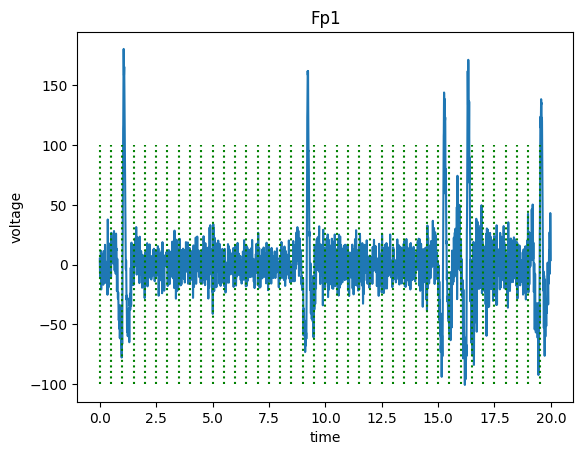

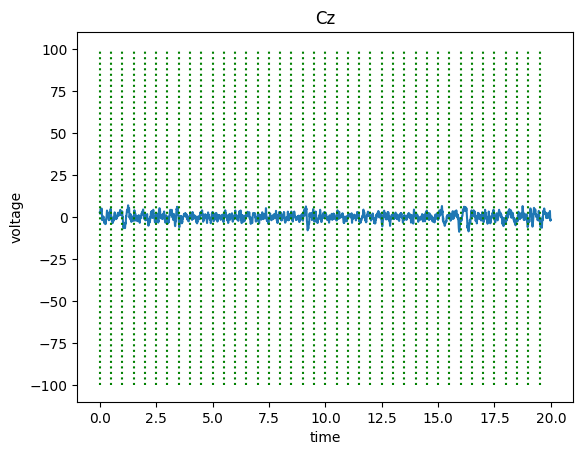

In [25]:

length = Fs*20
time_of_split = 0.5 #0.5 seconds of data
subjectNum = 0

time_pts = EEGStitched[subjectNum,-1,:length]

chNum = 1

Fp1_Data = plt.plot(time_pts,EEGStitched[subjectNum,chNum,:length])
x_vals = np.arange(0, time_pts[-1], time_of_split)

plt.ylabel( 'voltage' )
plt.xlabel( 'time' )
plt.title( channelNames[chNum]) 
ymin = -100
ymax = 100

plt.vlines(x=x_vals, ymin=ymin, ymax=ymax, colors='g', linestyles='dotted')
plt.show()

chNum = 0

Cz_Data = plt.plot(time_pts,EEGStitched[subjectNum,chNum,:length])
x_vals = np.arange(0, time_pts[-1], time_of_split)

plt.ylabel( 'voltage' )
plt.xlabel( 'time' )
plt.title( channelNames[chNum]) 
ymin = -100
ymax = 100

plt.vlines(x=x_vals, ymin=ymin, ymax=ymax, colors='g', linestyles='dotted')
plt.show()

It is much easier to spot the eye blinks on the channels on the forehead. Much harder for a channel like Cz. Hence, the idea is to use ML to extract eye blinks from 4 channel data where the eye blinks aren't very prominent. Eventually even single channel data.

I can take sliding windows of 1 second with slide of 0.5 seconds and use a voting system to get the final value. Voting from 2 consecutive epochs to identify the overlapping piece.

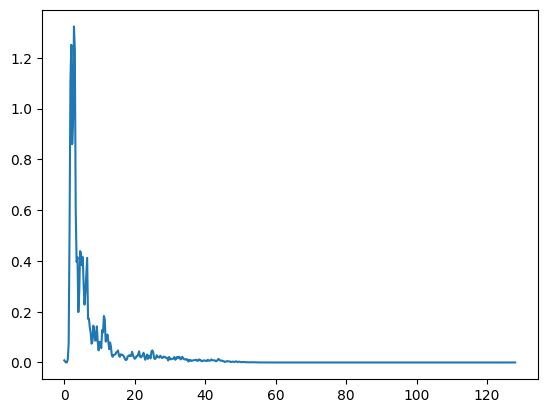

In [26]:
from scipy.signal import welch

frequencies, psd = welch(EEGStitched[0,0,:Fs*20], fs=Fs, nperseg=1024)
pwelchPlot = plt.plot(frequencies, psd)

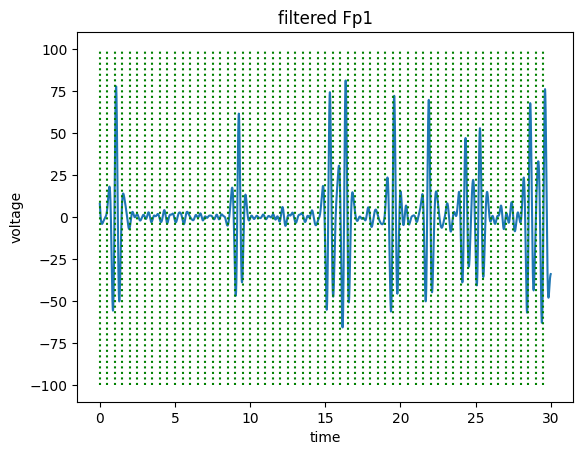

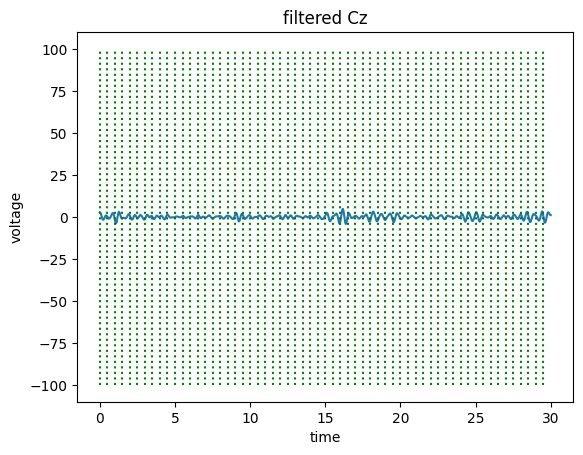

In [27]:
from signalProcessingHelper import zeroPhaseFreqFilter

length = Fs*30

signalSnipCz = EEGStitched[0,0,:length]
signalSnipFp1 = EEGStitched[0,1,:length]

filteredSignalSnipCz = zeroPhaseFreqFilter(signalSnipCz, 3, Fs, 'low', 4)
filteredSignalSnipFp1 = zeroPhaseFreqFilter(signalSnipFp1, 3, Fs, 'low', 4)


time_pts = EEGStitched[subjectNum,-1,:length]

Fp1_Data = plt.plot(time_pts,filteredSignalSnipFp1)
x_vals = np.arange(0, time_pts[-1], time_of_split)

chNum = 1

plt.ylabel( 'voltage' )
plt.xlabel( 'time' )
plt.title( "filtered " + channelNames[chNum]) 
ymin = -100
ymax = 100

plt.vlines(x=x_vals, ymin=ymin, ymax=ymax, colors='g', linestyles='dotted')
plt.show()

chNum = 0

Cz_Data = plt.plot(time_pts,filteredSignalSnipCz)
x_vals = np.arange(0, time_pts[-1], time_of_split)

plt.ylabel( 'voltage' )
plt.xlabel( 'time' )
plt.title( "filtered " + channelNames[chNum]) 
ymin = -100
ymax = 100

plt.vlines(x=x_vals, ymin=ymin, ymax=ymax, colors='g', linestyles='dotted')
plt.show()

Aim: single channel eye blink detection for channel not proximal to eyes (Cz)

Steps:
1. Break down into test, val and validation sets (3, 13, 3) DONE
Filter data? Optional
Scale data Optional
2. Epoch data DONE
3. Label test and validation sets and few val sets (3, 3, 3). Label using Fp1 data DONE
4. Create features to be used for data analysis from all the training and validation datasets
5. Check if PCA or others reveal any redundant features and reduce dimensions
6. Focus on training sets, run K means and random forest in unsupervised method and tune with labels
7. Hyper parameter tuning if required


In [28]:
from sklearn.model_selection import train_test_split
EEGStitchedCz = EEGStitched[:,0,:]
EEGStitchedFp1 = EEGStitched[:,1,:]

Cz_train, Cz_test, Fp1_train, Fp1_test = train_test_split(EEGStitchedCz,EEGStitchedFp1, test_size=3/19, random_state=8)
Cz_train, Cz_val, Fp1_train, Fp1_val = train_test_split(Cz_train,Fp1_train, test_size=3/16, random_state=8)
Cz_train_US, Cz_train_S, Fp1_train_US, Fp1_train_S = train_test_split(Cz_train,Fp1_train, test_size=3/13, random_state=8)


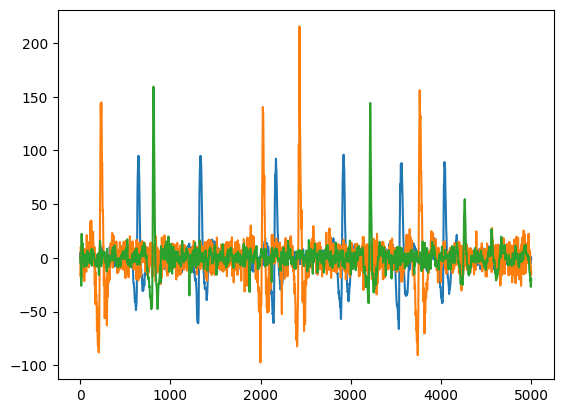

In [29]:
plt.plot(Fp1_train_S[0,:5000])
plt.plot(Fp1_train_S[1,:5000])
plt.plot(Fp1_train_S[2,:5000])

In [30]:

from scipy.stats import zscore
#zscore normalize all data
# Cz_train_US_zs = zscore(Cz_train_US,1)
# Cz_train_S_zs = zscore(Cz_train_S,1)
# Cz_val_zs = zscore(Cz_val,1)

Fp1_train_US_zs = zscore(Fp1_train_US,1)
Fp1_train_S_zs = zscore(Fp1_train_S,1)
Fp1_val_zs = zscore(Fp1_val,1)

Fp1_train_US_filt = zeroPhaseFreqFilter(Fp1_train_US_zs, 20, Fs, 'low', 4)
Fp1_train_S_filt = zeroPhaseFreqFilter(Fp1_train_S_zs, 20, Fs, 'low', 4)
Fp1_val_filt = zeroPhaseFreqFilter(Fp1_val_zs, 20, Fs, 'low', 4)

Fp1_test_zs = zscore(Fp1_test,1)
Fp1_test_filt = zeroPhaseFreqFilter(Fp1_test_zs, 20, Fs, 'low', 4)


In [31]:

#Epoch maker
# import importlib
# importlib.reload(signalProcessingHelper)

from signalProcessingHelper import epochSignal

epoch_length = np.int32(Fs/2) #1 second epochs
overlap = np.int32(0) #overlap 

Cz_train_US_Epochs = epochSignal(Cz_train_US, epoch_length, overlap) #epoch
print(Cz_train_US_Epochs.shape)

Fp1_train_US_Epochs = epochSignal(Fp1_train_US_filt, epoch_length, overlap) 
print(Fp1_train_US_Epochs.shape)

Cz_train_S_Epochs = epochSignal(Cz_train_S, epoch_length, overlap) #epoch
print(Cz_train_S_Epochs.shape)

Fp1_train_S_Epochs = epochSignal(Fp1_train_S_filt, epoch_length, overlap) 
print(Fp1_train_S_Epochs.shape)

Cz_val_Epochs = epochSignal(Cz_val, epoch_length, overlap) 
print(Cz_val_Epochs.shape)

Fp1_val_Epochs = epochSignal(Fp1_val_filt, epoch_length, overlap) 
print(Fp1_val_Epochs.shape)

Cz_test_Epochs = epochSignal(Cz_test, epoch_length, overlap) 
print(Cz_test_Epochs.shape)

Fp1_test_Epochs = epochSignal(Fp1_test_filt, epoch_length, overlap) 
print(Fp1_test_Epochs.shape)



(10, 600, 128)
(10, 600, 128)
(3, 600, 128)
(3, 600, 128)
(3, 600, 128)
(3, 600, 128)
(3, 600, 128)
(3, 600, 128)


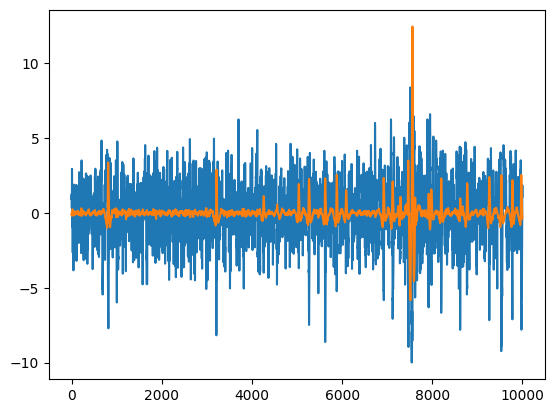

In [32]:
#Label maker
# plt.plot(Fp1_train_S_filt[0,:10000])
# plt.plot(Fp1_train_S_filt[1,:10000])
plt.plot(Cz_train_S[2,0:10000])
plt.plot(Fp1_train_S_filt[2,0:10000])


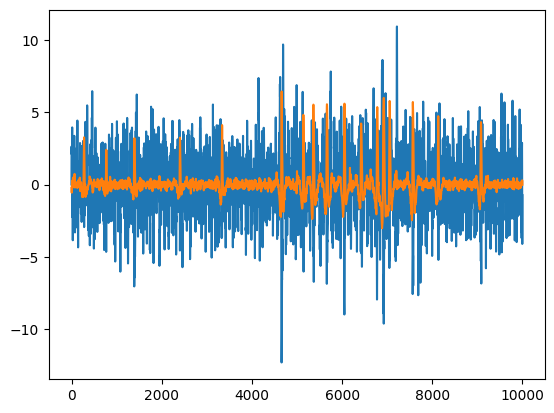

In [33]:
plt.plot(Cz_val[2,0:10000])
plt.plot(Fp1_val_filt[2,0:10000])


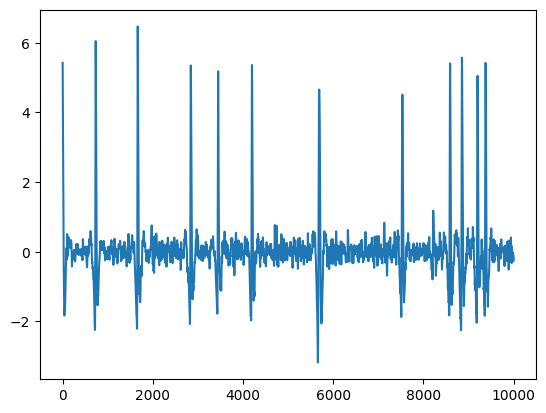

In [34]:
plt.plot(Fp1_test_filt[2,0:10000])

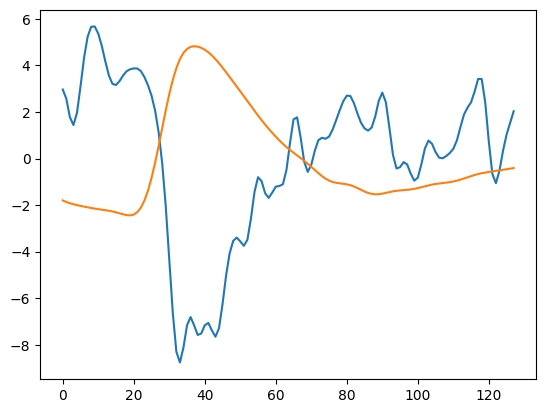

In [35]:
plt.plot(Cz_val_Epochs[0,1])
plt.plot(Fp1_val_Epochs[0,1])


In [36]:
Cz_val_Labels = (np.max(Fp1_val_Epochs, axis=2) > 2).astype(int)
Cz_train_S_Labels = (np.max(Fp1_train_S_Epochs, axis=2) > 2).astype(int)
Cz_test_Labels = (np.max(Fp1_test_Epochs, axis=2) > 2).astype(int)

print(Cz_test_Labels.shape)


(3, 600)


In [37]:
#collapse the 3d array into 2d to create dataframes

Cz_train_US_df = pd.DataFrame(Cz_train_US_Epochs.reshape(-1, Cz_train_US_Epochs.shape[2]))
Cz_train_S_df = pd.DataFrame(Cz_train_S_Epochs.reshape(-1, Cz_train_S_Epochs.shape[2]))
Cz_val_df = pd.DataFrame(Cz_val_Epochs.reshape(-1, Cz_val_Epochs.shape[2]))
Cz_test_df = pd.DataFrame(Cz_test_Epochs.reshape(-1, Cz_test_Epochs.shape[2]))

Cz_train_S_Labels = pd.DataFrame(Cz_train_S_Labels.reshape(-1))
Cz_val_Labels = pd.DataFrame(Cz_val_Labels.reshape(-1))
Cz_test_Labels = pd.DataFrame(Cz_test_Labels.reshape(-1))
print(Cz_train_S_Labels.shape)


(1800, 1)


In [39]:
#Save dataframes
Cz_train_US_df.to_csv('Cz_train_US_df.csv', index=False)
Cz_train_S_df.to_csv('Cz_train_S_df.csv', index=False)
Cz_val_df.to_csv('Cz_val_df.csv', index=False)
Cz_test_df.to_csv('Cz_test_df.csv', index=False)

Cz_train_S_Labels.to_csv('Cz_train_S_Labels.csv', index=False)
Cz_val_Labels.to_csv('Cz_val_Labels.csv', index=False)
Cz_test_Labels.to_csv('Cz_test_Labels.csv', index=False)